# Porto-serqruo-safe-prediction
- Porto-serqruo는 보험회사 이름이다. 
- 이 보험회사는 자동차 보험 청구 예측을 통해 보험 비용을 관리하려고 한다. 
- 예측이 부정확하면 좋은 운전자의 보험 비용이 상승하고, 예측이 정확하면 나쁜 운전자의 경우 가격이 낮아진다. 
- 목표 : 운전자가 내년에 자동차 보험 청구를 시작할 확률울 예측하는 모델을 구축 해야함.

In [22]:
# Loading package

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Imputer was deprecated 3 versions ago and remove in 0.22
# from sklearn.preprocessing import Imputer 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_columns',100)

## 1. 데이터 확인
- Loading data

In [23]:
train = pd.read_csv('../data/porto-seguro-safe-driver-prediction/train.csv')
test = pd.read_csv('../data/porto-seguro-safe-driver-prediction/test.csv')

- 데이터 설명 
    - 자동차 보험 계약자가 클레임을 제기 할 확률을 예측
    - 유사한 그룹화에 속하는 변수(Feature)는 변수 이름에 태그가 지정된다.(예: ind, reg, car, calc)
    - 변수 이름에는 이항 변수를 나타내는 `bin` 전두사가 포함되어 있거나, 범주형 변수을 나타내는 `cat` 등이 있다.
    - 이러한 지정이 없는 형상은 연속형 또는 순서형이다.
    - -1 값은 관측치에서 형상이 누락되었음을 나타낸다.
    - target 열은 해당 정책 보유자에 대한 청구가 제기되었는지 여부를 나타낸다.

In [24]:
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [25]:
train.tail()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
595207,1488013,0,3,1,10,0,0,0,0,0,1,0,0,0,0,0,13,1,0,0,0.5,0.3,0.692820,10,1,-1,0,1,1,1,1,0,1,31,3,0.374166,0.684631,0.385487,2.645751,0.4,0.5,0.3,3,0,9,0,9,1,12,4,1,9,6,0,1,1,0,1,1
595208,1488016,0,5,1,3,0,0,0,0,0,1,0,0,0,0,0,6,1,0,0,0.9,0.7,1.382027,9,1,-1,0,-1,15,0,0,2,1,63,2,0.387298,0.972145,-1.000000,3.605551,0.2,0.2,0.0,2,4,8,6,8,2,12,4,1,3,8,1,0,1,0,1,1
595209,1488017,0,1,1,10,0,0,1,0,0,0,0,0,0,0,0,12,1,0,0,0.9,0.2,0.659071,7,1,-1,0,-1,1,1,1,2,1,31,3,0.397492,0.596373,0.398748,1.732051,0.4,0.0,0.3,3,2,7,4,8,0,10,3,2,2,6,0,0,1,0,0,0
595210,1488021,0,5,2,3,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.9,0.4,0.698212,11,1,-1,0,-1,11,1,1,2,1,101,3,0.374166,0.764434,0.384968,3.162278,0.0,0.7,0.0,4,0,9,4,9,2,11,4,1,4,2,0,1,1,1,0,0
595211,1488027,0,0,1,8,0,0,1,0,0,0,0,0,0,0,0,7,1,0,0,0.1,0.2,-1.000000,7,0,-1,0,-1,0,1,0,2,1,34,2,0.400000,0.932649,0.378021,3.741657,0.4,0.0,0.5,2,3,10,4,10,2,5,4,4,3,8,0,1,0,0,0,0


- 위의 데이터 설명에서 참고할 점 다시 요약
    - 이항 변수
    - 범주화 값이 숫자인 범주화 변수
    - `int` or `float` 값인 변수
    - `-1` 누락값
    - target 변수 과 ID 변수

In [26]:
# 데이터 갯수 확인
train.shape

(595212, 59)

In [27]:
# 동일한 변수값이 들어가 있을 경우, 삭제하고 다시 데이터 갯수 확인
train.drop_duplicates()
train.shape

(595212, 59)

In [28]:
# test 데이터의 row가 하나 없는 이유는 target 변수가 생략되었기 때문이다. 이 부분이 우리가 예측해야 할 부분이다. 
test.shape

(892816, 58)

In [29]:
# 14개의 범주형의 더미변수를 만들어보자. `bin` 변수는 이미 이상 변수여서 더미화 할 필요없다.
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              595212 non-null  int64  
 1   target          595212 non-null  int64  
 2   ps_ind_01       595212 non-null  int64  
 3   ps_ind_02_cat   595212 non-null  int64  
 4   ps_ind_03       595212 non-null  int64  
 5   ps_ind_04_cat   595212 non-null  int64  
 6   ps_ind_05_cat   595212 non-null  int64  
 7   ps_ind_06_bin   595212 non-null  int64  
 8   ps_ind_07_bin   595212 non-null  int64  
 9   ps_ind_08_bin   595212 non-null  int64  
 10  ps_ind_09_bin   595212 non-null  int64  
 11  ps_ind_10_bin   595212 non-null  int64  
 12  ps_ind_11_bin   595212 non-null  int64  
 13  ps_ind_12_bin   595212 non-null  int64  
 14  ps_ind_13_bin   595212 non-null  int64  
 15  ps_ind_14       595212 non-null  int64  
 16  ps_ind_15       595212 non-null  int64  
 17  ps_ind_16_

## 2. Metadata
- 데이터 관리를 용이하게 하기 위해 Feature에 대한 메타 정보를 DataFrame에 저장한다. 
- 분석, 시각화, 모델링 등을 위해 특정 변수를 선택하고자 할 때 유용할 것이다.
- 명확하게 분리해보자.
    - role : input, ID, target
    - level : nomial, interval, ordinal, binary
    - keep : True or False
    - dtype : int, float, str

In [30]:
data = []
for f in train.columns:
    # Define the role
    if f == 'target':
        role = 'target'
    elif f == 'id':
        role = 'id'
    else:
        role = 'input'
        
    # Define the level    
    if 'bin' in f or f == 'target':        
        level = 'binary' # 이상 변수
    elif 'cat' in f or f == 'id':
        level = 'nominal' # 방향, 숫자의미 없이 카테고리 변수 , 명목 척도
    elif train[f].dtype == 'float64':                
        level = 'interval' # 등간척도, 대표적 예는 온도, 0도가 열이 없는건 아니다.  cf) 비율 척도 ratio scale, 예 : 키 몸무게, 0은 아무것도 없는 것을 의미함.
    elif train[f].dtype == 'int64':
        level = 'ordinal' # 랭킹, 순서, 스케일링등 숫자가 의미 있는 변수, 서열 척도

    # id value는 제외
    keep = True
    if f == 'id':
        keep = False

    # data type 정의 
    dtype = train[f].dtype
    
    # 변수의 메타데이터를 포함한 dict 만들기 
    f_dict = {
        'varname': f,
        'role': role,
        'level': level,
        'keep': keep, 
        'dtype': dtype
    }
    level = ''
    data.append(f_dict)

meta = pd.DataFrame(data, columns=['varname', 'role', 'level','keep','dtype'])
meta.set_index('varname', inplace=True)

In [31]:
meta

,role,level,keep,dtype
varname,,,,
id,id,nominal,False,int64
target,target,binary,True,int64
ps_ind_01,input,ordinal,True,int64
ps_ind_02_cat,input,nominal,True,int64
ps_ind_03,input,ordinal,True,int64
ps_ind_04_cat,input,nominal,True,int64
ps_ind_05_cat,input,nominal,True,int64
ps_ind_06_bin,input,binary,True,int64
ps_ind_07_bin,input,binary,True,int64


- 삭제되지 않은 모든 nominal variables를 추출하는 예제

In [32]:
meta[(meta.level == 'nominal') & (meta.keep)].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

In [33]:
#  역할 및 수준별 변수의 갯수를 볼수 있음.

In [34]:
pd.DataFrame({'count' : meta.groupby(['role', 'level'])['role'].size()}).reset_index()

,role,level,count
0,id,nominal,1
1,input,binary,17
2,input,interval,10
3,input,nominal,14
4,input,ordinal,16
5,target,binary,1


## 3. 기술 통계(Descriptive Statistics)
- 데이터 프레임에 기술 통계을 적용
- 범주형 변수와 ID 변수에 대한 평균, std, ...를 계산하는 것은 옳지않으므로, 나중에 시각적으로 탐구
- 메타 파일을 활용하여 기술 통계량을 계산할 변수를 쉽게 선택 가능 

In [35]:
# Interval variables
v = meta[(meta.level == 'interval') & (meta.keep)].index # interval : 데이터 형식이 float, keep : id 컬럼 제외
train[v].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


In [36]:
# Oridinal variable
v = meta[(meta.level == 'ordinal') & (meta.keep)].index 
train[v].describe()

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_car_11,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,1.900378,4.423318,0.012451,7.299922,2.346072,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026
std,1.983789,2.699902,0.127545,3.546042,0.832548,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652
min,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,5.000000,2.000000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,1.000000,4.000000,0.000000,7.000000,3.000000,2.000000,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,3.000000,6.000000,0.000000,10.000000,3.000000,3.000000,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,7.000000,11.000000,4.000000,13.000000,3.000000,5.000000,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,19.000000,10.000000,13.000000,23.000000


In [37]:
# Binary variable
v = meta[(meta.level == 'binary') & (meta.keep)].index 
train[v].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


- train 데이터의 분포는 3.645%로, 균형이 매우 맞지 않는다.
- 평균을 통해 대부분의 변수의 값이 대부분의 경우 0이라고 결론을 내릴 수 있다.

## 4. 불균형 클래스 처리
위에서 언급했듯이 목표=1을 가진 기록의 비율은 목표=0보다 훨씬 적다. 이것은 정확성은 크지만 실제에 있어서 어떠한 부가 가치를 지닌 모델을 이끌어낼 수 있다. 이 문제를 해결하기 위한 두 가지 가능한 전략은 다음과 같다.

- 타겟=1로 레코드를 oversampling(오버샘플링)
- 타겟=0으로 레코드 undersampling(과소 샘플링)

물론 더 많은 전략들이 있고 MachineLearningMastery.com은 멋진 개요를 제공한다. 우리는 훈련 세트가 꽤 크기 때문에 undersampling(과소 샘플링)으로 갈 수 있다.

In [38]:
desired_apriori = 0.10

# target value(목표값) 당 지수 가져오기
idx_0 = train[train.target == 0].index
idx_1 = train[train.target == 1].index

# target value(목표값)당 원래 레코드 수 가져오기
nb_0 = len(train.loc[idx_0])
nb_1 = len(train.loc[idx_1])

# 언더샘플링 비율 과 타켓이 0 일때 레코드 갯수 결과 계산
undersampling_rate = ((1-desired_apriori)*nb_1)/(nb_0*desired_apriori)
undersampled_nb_0 = int(undersampling_rate*nb_0)
print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
print('Number of records with target=0 after undersampling: {}'.format(undersampled_nb_0))


# 목표값=0이 있는 레코드를 임의로 선택하여 원하는 사전 정보를 얻으십시오.
undersampled_idx = shuffle(idx_0, random_state = 37, n_samples=undersampled_nb_0)

#나머지 인덱스를 사용하여 list 구성
idx_list = list(undersampled_idx) + list(idx_1)

# 언더샘플링할 결과 다시 담기 
train = train.loc[idx_list].reset_index(drop=True)


Rate to undersample records with target=0: 0.34043569687437886
Number of records with target=0 after undersampling: 195246


## 5. 데이터 품질 검사

- missing values 검사
    - missing value는 `-1`로 표현함

In [39]:
vars_with_missing=[]

for f in train.columns:
    missings = train[train[f] == -1][f].count()
    if missings > 0:
        vars_with_missing.append(f)
        missings_perc = missings/train.shape[0]
        
        print('Variable {} has {} records ({:.2%}) with missing values'.format(f, missings, missings_perc))
print('\n In total, there are  {} variables with missing values'.format(len(vars_with_missing)))

Variable ps_ind_02_cat has 103 records (0.05%) with missing values
Variable ps_ind_04_cat has 51 records (0.02%) with missing values
Variable ps_ind_05_cat has 2256 records (1.04%) with missing values
Variable ps_reg_03 has 38580 records (17.78%) with missing values
Variable ps_car_01_cat has 62 records (0.03%) with missing values
Variable ps_car_02_cat has 2 records (0.00%) with missing values
Variable ps_car_03_cat has 148367 records (68.39%) with missing values
Variable ps_car_05_cat has 96026 records (44.26%) with missing values
Variable ps_car_07_cat has 4431 records (2.04%) with missing values
Variable ps_car_09_cat has 230 records (0.11%) with missing values
Variable ps_car_11 has 1 records (0.00%) with missing values
Variable ps_car_14 has 15726 records (7.25%) with missing values

 In total, there are  12 variables with missing values


- ps_car_03_cat(68.39%), ps_car_05_cat(44.26%)은 missing value(결측치)비율이 높다. 정확하게 측정할 수 없으므로 변수에서 제거한다.
- 대부분의 범주형 변수(categorical variable)은 -1로 둔다.
- 연속형 변수 mean 값으로, 순서형 변수는 mode값으로 대체한다.

In [40]:
# 결측치 비율이 높은 두 항목을 삭제 한다.
vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']
train.drop(vars_to_drop, inplace=True, axis=1)
meta.loc[(vars_to_drop), 'keep'] = False

In [41]:
mean_imp = SimpleImputer(missing_values=-1, strategy='mean')
mode_imp = SimpleImputer(missing_values=-1, strategy='most_frequent')
train['ps_reg_03'] = mean_imp.fit_transform(train[['ps_reg_03']]).ravel()
train['ps_car_11'] = mean_imp.fit_transform(train[['ps_car_11']]).ravel()
train['ps_car_14'] = mean_imp.fit_transform(train[['ps_car_14']]).ravel()
train['ps_car_02_cat'] = mode_imp.fit_transform(train[['ps_car_02_cat']]).ravel()

- 범주형 변수의 집합원 갯수 체크
    - 카디널리티는 변수에서 다른 값의 수를 가리킨다. 
    - 나중에 범주형 변수에서 더미 변수를 만들 것이기 때문에 많은 구별되는 값을 갖는 변수가 있는지 확인할 필요가 있다. 
    - 이러한 변수들이 많은 더미 변수를 야기할 수 있기 때문에 다르게 다루어야 한다.

In [42]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index
for f in v:
    dist_values = train[f].value_counts().shape[0]
    print('Variable {} has {} distinct values'.format(f, dist_values))

Variable ps_ind_02_cat has 5 distinct values
Variable ps_ind_04_cat has 3 distinct values
Variable ps_ind_05_cat has 8 distinct values
Variable ps_car_01_cat has 13 distinct values
Variable ps_car_02_cat has 2 distinct values
Variable ps_car_04_cat has 10 distinct values
Variable ps_car_06_cat has 18 distinct values
Variable ps_car_07_cat has 3 distinct values
Variable ps_car_08_cat has 2 distinct values
Variable ps_car_09_cat has 6 distinct values
Variable ps_car_10_cat has 3 distinct values
Variable ps_car_11_cat has 104 distinct values


- ps_car_11_cat 는 104개로 유니크한 값이 존재하지만, 여전히 논리적(reasonable)이다.

In [43]:
# 아래 코드는 ps_car_11_cat과 같이 유니크한 값을 데이터를 분리하여 새로운 데이터를 생성해주는 코드이다.
# Script by https://www.kaggle.com/ogrellier
# Code: https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [44]:
train_encoded, test_encoded = target_encode(train['ps_car_11_cat'], 
                                            test['ps_car_11_cat'],
                                            target=train.target,
                                            min_samples_leaf=100,
                                            smoothing=10,
                                            noise_level=0.01
                                           )

train['ps_car_11_cat_te'] =train_encoded
train.drop('ps_car_11_cat', axis=1, inplace=True)
meta.loc['ps_car_11_cat_te', 'keep'] = False # meta 정보에도 업데이트
test['ps_car_11_cat_te'] =test_encoded
test.drop('ps_car_11_cat', axis=1, inplace=True)

In [79]:
# 원본데이터에도 지워졌으니, meta에서도 삭제 
meta.drop(['ps_car_11_cat'], inplace=True)

## 6. EDA Visualization

- 범주형 변수
    - 범주형 변수와 target value가 1인 customer의 비율에 대해서 알자보자

<Figure size 432x288 with 0 Axes>

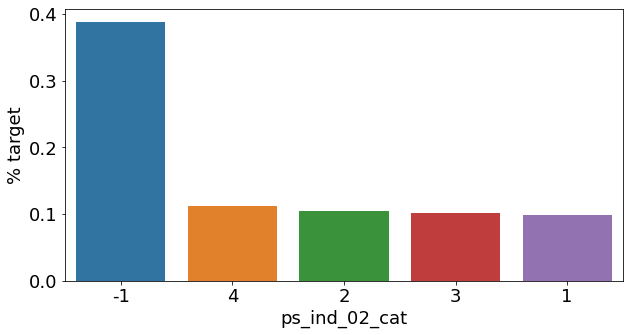

<Figure size 432x288 with 0 Axes>

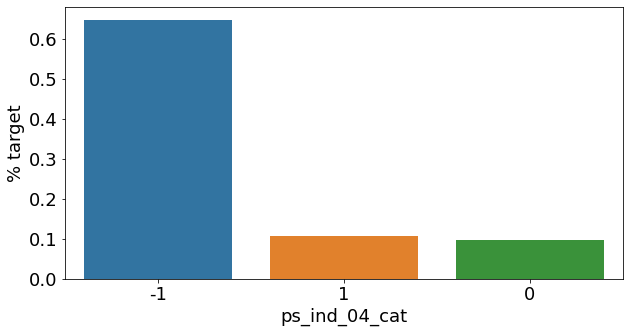

<Figure size 432x288 with 0 Axes>

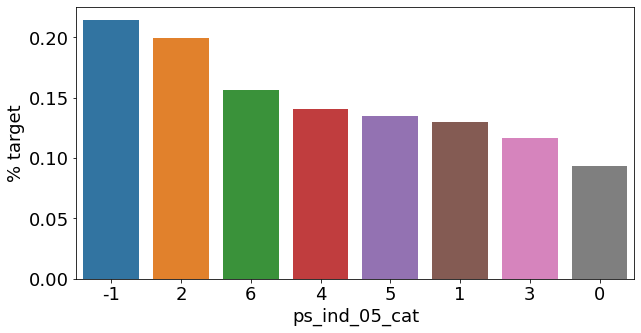

<Figure size 432x288 with 0 Axes>

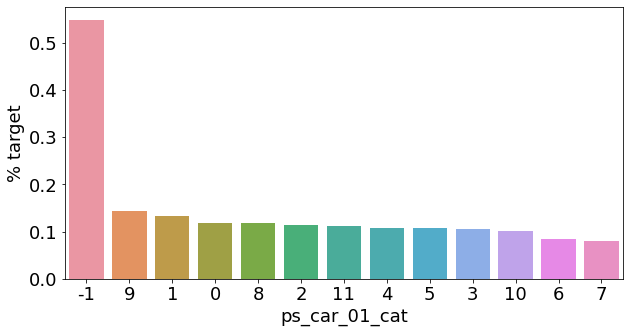

<Figure size 432x288 with 0 Axes>

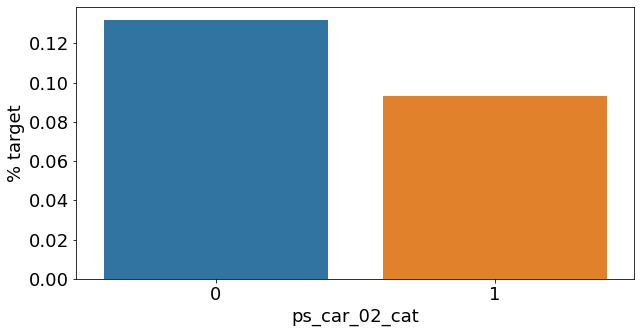

<Figure size 432x288 with 0 Axes>

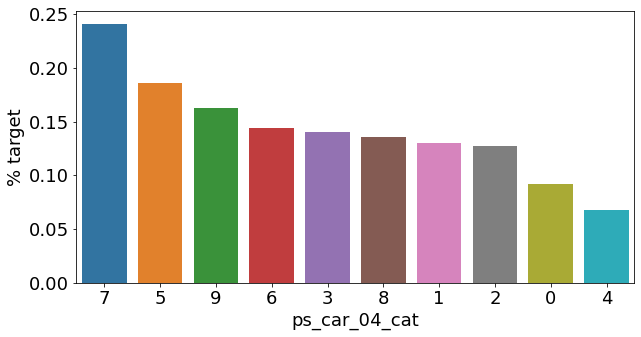

<Figure size 432x288 with 0 Axes>

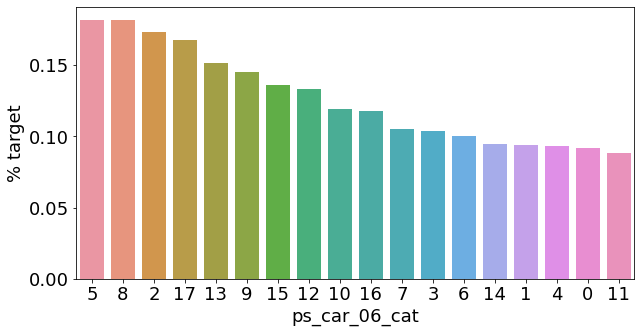

<Figure size 432x288 with 0 Axes>

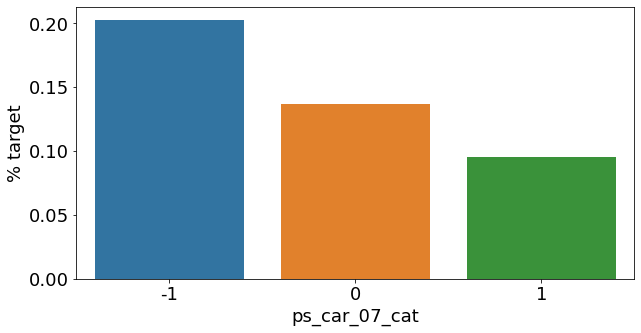

<Figure size 432x288 with 0 Axes>

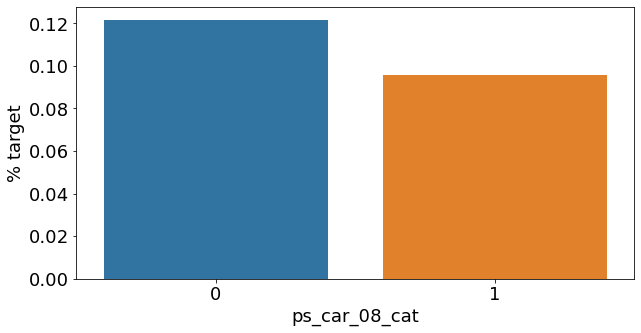

<Figure size 432x288 with 0 Axes>

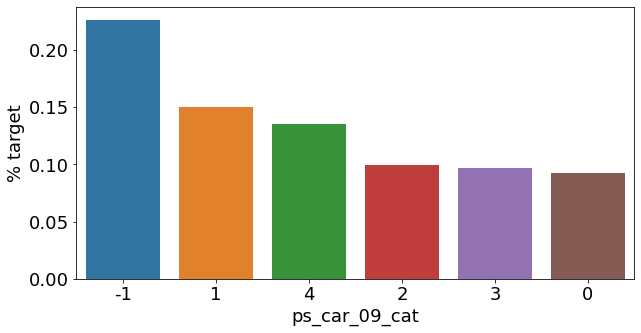

<Figure size 432x288 with 0 Axes>

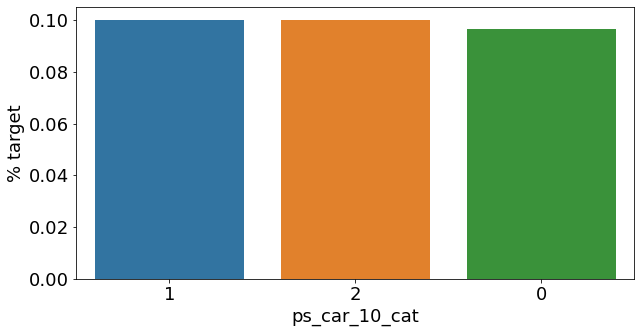

KeyError: "['ps_car_11_cat'] not in index"

<Figure size 432x288 with 0 Axes>

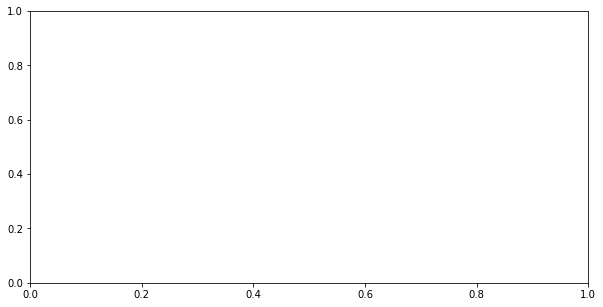

In [45]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index

for f in v:
    plt.figure()
    fig, ax = plt.subplots(figsize=(10,5))
    # 범주형 값당 target value가 1인 비율 계산
    cat_perc = train[[f, 'target']].groupby([f], as_index=False).mean()
    cat_perc.sort_values(by='target', ascending=False, inplace=True)
    # Bar plot
    # target 평균값으로 bar 내림차순 정렬
    sns.barplot(ax=ax, x=f, y ='target', data=cat_perc, order=cat_perc[f])
    plt.ylabel('% target', fontsize=18)
    plt.xlabel(f, fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.show()
    

- Interval variables
    - 수치 변수간의 상관관계를 측정한다. heatmap 은 변수간의 상관관계를 시각화하여 보여주는데 좋은 방법이다. 

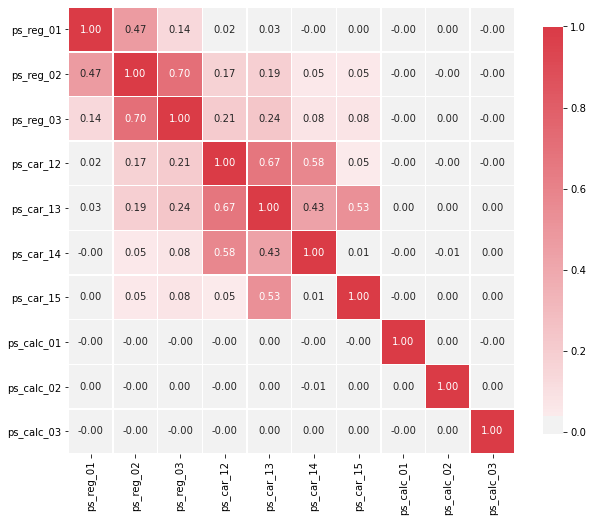

In [47]:
def corr_heatmap(v):
    correlations = train[v].corr()
    
    # 두가지 색상으로 범위를 나타냄
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',
               square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .75})
    plt.show()
    
v = meta[(meta.level == 'interval') & (meta.keep)].index
corr_heatmap(v)

- 강한 상관관계를 띄는 것
    - ps_reg_03 와 ps_reg_02 : 0.7
    - ps_car_13 와 ps_car_12 : 0.67
    - ps_car_14 와 ps_car_12 : 0.58
    - ps_car_13 와 ps_car_15 : 0.53
    
- Seaborn은 변수들 사이의 (선형) 관계를 시각화할 수 있는 몇 가지 유용한 플롯을 가지고 있다.  변수들 사이의 관계를 시각화하기 위해 pairplot을 사용할 수 있다. 하지만 heatmap에서 이미 제한된 수의 상관 변수를 보여 주었기 때문에, 우리는 각각의 높은 상관 관계를 가진 변수들을 개별적으로 살펴보도록 하겠다.

In [50]:
# train data 중 임의로 10%만 추출함.
s = train.sample(frac=0.1)

- ps_reg_02 ans ps_reg_03
    - 회귀선이 보여주듯이 이들 변수 사이에는 선형 관계가 있다. 
    -  hue parameter 덕분에 target=0과 target=1의 회귀선이 동일함을 알 수 있다

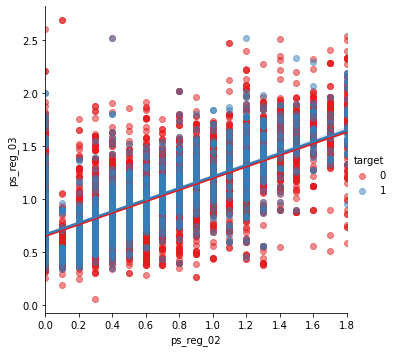

In [55]:
sns.lmplot(x='ps_reg_02', y='ps_reg_03', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.5})
plt.show()

- ps_car_12 와 ps_car_13

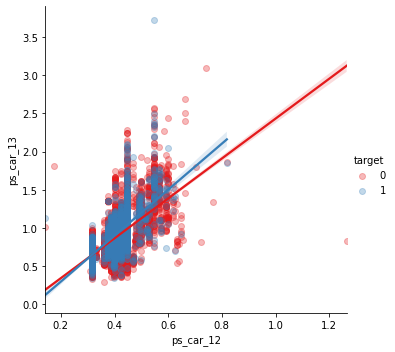

In [60]:
sns.lmplot(x='ps_car_12', y='ps_car_13', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

- ps_car_12 와 ps_car_14

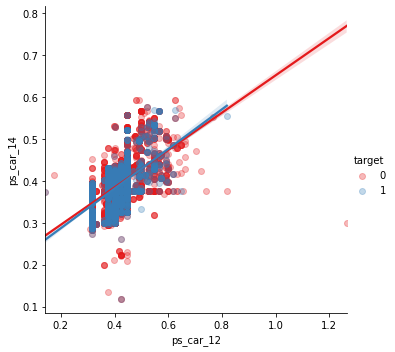

In [61]:
sns.lmplot(x='ps_car_12', y='ps_car_14', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

- ps_car_13 와 ps_car_15

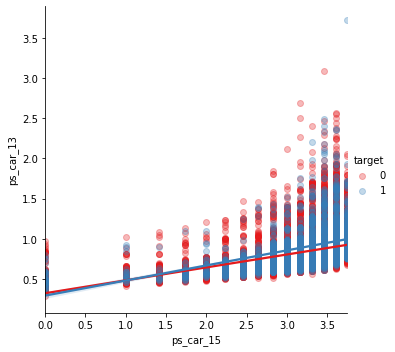

In [63]:
sns.lmplot(x='ps_car_15', y='ps_car_13', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

- 어떤 상관 변수를 유지할 것인가 결정해야한다. 변수에 대한 주성분 분석(PCA)를 수행하여 치수를 줄일 수 있다. 
- 상관 변수의 수가 다소 적기 때문에, 모델이 무거운 heavy-lifting을 진행한다.

- 순서형 변수의 상관관계 확인

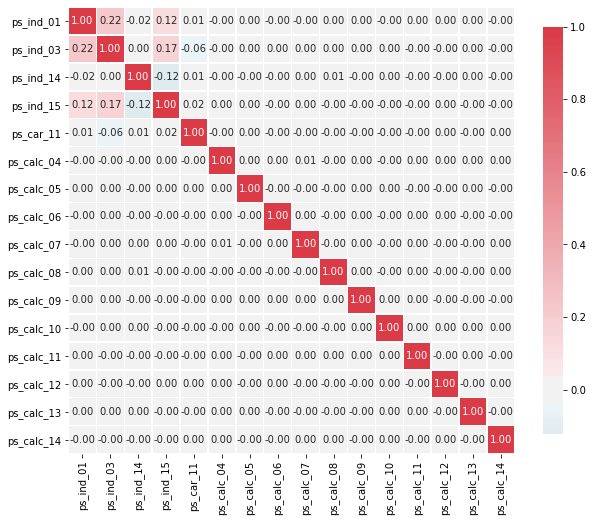

In [65]:
v = meta[(meta.level == 'ordinal') & (meta.keep)].index
corr_heatmap(v)

- 순서형 변수는 변수들 간의 높은 상관관계가 나타나지 않는다. 
- 하지만, 우리는 목표값을 그룹화 할때, 분포가 어떻게 되는지 살펴봐야한다.

## 7. Feature Engineering

- dummy 변수 만들기
    - 범주형 변수의 값은 순서나 크기를 나타내지 않는다. 예를 들어 범주 2는 범주 1의 두 배가 아니다. 
    - 그러므로 우리는 그것을 다룰 더미 변수를 만들 수 있다. 이 정보는 원래 변수의 범주에 대해 생성된 다른 더미 변수에서 파생될 수 있으므로 첫 번째 더미 변수를 삭제한다.

In [76]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index
print('Before dummification we have {} variables in train'.format(train.shape[1]))
train = pd.get_dummies(train, columns=v, drop_first=True)
print('After dummification we have {} variables in train'.format(train.shape[1]))

Before dummification we have 57 variables in train
After dummification we have 108 variables in train


## 8. Feature 선택

- classifier 알고리즘을 적용하기 위해선 분산이 낮거나 0인 변수는 제거해야한다.(넣어도 의미가 없기때문)
- Sklearn 을 사용하면 기본적으로 분산이 0인경우 삭제한다.
- 1% 이하보다 작은 분산을 가진 변수를 삭제하면 31개 변수가 삭제 된다.

In [66]:
selector = VarianceThreshold(threshold=.01) # 1% 이하인것은 삭제
selector.fit(train.drop(['id','target'], axis=1)) # id와 target 변수를 제외하고 fit 시킨다.

f = np.vectorize(lambda x : not x) # 부울 배열 요소를 전환하기 위한 함수

v = train.drop(['id','target'], axis=1).columns[f(selector.get_support())]
print('{} variables have too low vairance.'.format(len(v)))
print('These variables are {}'.format(list(v)))

8 variables have too low vairance.
These variables are ['ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_car_10_cat', 'ps_car_12', 'ps_car_14', 'ps_car_11_cat_te']


- 만약 우리가 분산에 근거하여 선택한다면 우리는 오히려 많은 변수를 잃을 수 있다. 
- 하지만 우리는 변수가 많지 않기 때문에 classifier가 선택하도록 한다. 
- 변수가 더 많은 데이터 세트의 경우 이렇게 하면 처리 시간이 단축될 수 있다.

- Sklearn은 또한 다른 특징 선택 방법과 함께 제공된다. 
- 이러한 방법 중 하나는 SelectFromModel이며,이것은 다른 classifier가 최적의 feature을 선택하고 계속하도록 한다.
- 아래 랜덤 포레스트는 어떻게 하는지 알아보자.

- 랜덤포레스트와 SelectFromModel에 의해 Feature 선택
    - 여기서는 랜덤 포레스트의 Feature Importance를 기준으로 Feature를 선택한다. 
    - 그런 다음 Sklearn의 SelectFromModel을 사용하여 유지할 변수 수를 지정할 수 있다. 
    - Feature Importance 수준에서 threshold(임계값)을 수동으로 설정할 수 있다. 
    - 하지만 여기에선 간단하게 상위 50%의 가장 좋은 변수를 선택한다.

In [90]:
X_train = train.drop(['id', 'target'], axis=1)
y_train = train['target']

feat_labels = X_train.columns

rf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)

rf.fit(X_train, y_train)
importance = rf.feature_importances_

indices = np.argsort(rf.feature_importances_)[::-1]

In [89]:
# 컬럼별 중요도 확인
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importance[indices[f]]))

 1) ps_car_11_cat_te               0.052553
 2) ps_car_13                      0.051837
 3) ps_reg_03                      0.047464
 4) ps_car_14                      0.040319
 5) ps_calc_10                     0.034157
 6) ps_calc_14                     0.033609
 7) ps_calc_11                     0.031921
 8) ps_ind_15                      0.030636
 9) ps_ind_03                      0.030089
10) ps_calc_01                     0.029117
11) ps_calc_03                     0.029027
12) ps_calc_02                     0.028940
13) ps_reg_02                      0.028687
14) ps_calc_13                     0.027166
15) ps_calc_08                     0.025785
16) ps_calc_07                     0.025747
17) ps_car_15                      0.024939
18) ps_calc_06                     0.024158
19) ps_calc_09                     0.023499
20) ps_ind_01                      0.022657
21) ps_reg_01                      0.022633
22) ps_calc_05                     0.022208
23) ps_calc_04                  

- SelectFromModel을 사용하여 적절한 classifier을 구체화할지, feature importance를 위한 임계치를 정할 수 있다. 
- get_support 방법을 사용하면 train 데이터의 변수 갯수 제한을 줄 수 있다.

In [1]:
sfm = SelectFromModel(rf, threshold='median', prefit=True)
print('Number of feature before selection: {}'.format(X_train.shape[1]))
n_features = sfm.transform(X_train).shape[1]
print('Number of feature after selection: {}'.format(n_features))
selected_vars = list(feat_labels[sfm.get_support()])

NameError: name 'SelectFromModel' is not defined

In [92]:
train = train[selected_vars + ['target']]

## 9. Feature 확장

- 전에 언급했던 것 처럼, train data에 standard scaling을 적용해야한다. 
- 몇몇 classifiers는 스케일링을 하는게 더 성능이 좋게 나온다.

In [95]:
scaler = StandardScaler()
scaler.fit_transform(train.drop(['target'], axis=1))

array([[-0.45941104, -1.26665356,  1.25877984, ...,  0.4530072 ,
        -0.69295208,  0.82684717],
       [ 1.55538958,  0.95034274,  1.25877984, ...,  0.4530072 ,
        -0.69295208,  0.82684717],
       [ 1.05168943, -0.52765479,  1.25877984, ...,  0.4530072 ,
        -0.69295208,  0.82684717],
       ...,
       [-0.9631112 ,  0.58084336, -0.7944201 , ...,  0.4530072 ,
        -0.69295208, -1.20941334],
       [-0.9631112 , -0.89715418,  1.25877984, ..., -2.20747042,
        -0.69295208,  0.82684717],
       [-0.45941104, -1.26665356, -0.7944201 , ...,  0.4530072 ,
        -0.69295208,  0.82684717]])